In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
import seaborn as sns

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk',"2017-09-28","2021-09-24")
data.drop(["Adj Close"],axis=1,inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# # data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
# data["% Change"]=data["Close"].pct_change()
data["Price Change"]=talib.ROCR(data['Close'].values, timeperiod=5)
# data['3day MA'] = data['Close'].shift(1).rolling(window = 7).mean()
# data['10day MA'] = data['Close'].shift(1).rolling(window = 14).mean()
# data['30day MA'] = data['Close'].shift(1).rolling(window = 21).mean()
data['Std_dev']= data['Close'].rolling(5).std()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['MACD']=
macd, signal, hist=talib.MACDFIX(data['Close'].values,signalperiod=9)
data['MACD']=macd
# alues, data['Close'].values, 7)
data

,Open,High,Low,Close,Volume,H-L,O-C,Price Change,Std_dev,RSI,MACD
Date,,,,,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,22520013,1.049995,-0.200005,NaN,NaN,NaN,NaN
2017-09-29,76.500000,76.900002,76.300003,76.550003,16766252,0.599998,0.050003,NaN,NaN,NaN,NaN
2017-10-03,76.800003,77.449997,76.699997,77.449997,24369212,0.750000,0.649994,NaN,NaN,NaN,NaN
2017-10-04,77.500000,77.949997,77.500000,77.849998,21197563,0.449997,0.349998,NaN,NaN,NaN,NaN
2017-10-06,77.599998,77.800003,77.199997,77.349998,23715110,0.600006,-0.250000,NaN,0.681542,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,40.599998,40.599998,39.599998,40.000000,19553563,1.000000,-0.599998,0.990099,0.396233,24.116608,-0.749808
2021-09-17,39.700001,40.400002,39.099998,40.250000,28266370,1.300003,0.549999,0.984108,0.269259,34.315393,-0.734137
2021-09-20,39.900002,39.950001,38.950001,39.000000,23796781,1.000000,-0.900002,0.958231,0.517687,19.235038,-0.807306


In [4]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [5]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
# data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data=data

In [7]:
data.isnull().sum()

Open             0
High             0
Low              0
Close            0
Volume           0
H-L              0
O-C              0
Price Change     5
Std_dev          4
RSI              7
MACD            33
dtype: int64

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
H-L             0
O-C             0
Price Change    0
Std_dev         0
RSI             0
MACD            0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Volume,H-L,O-C,Price Change,Std_dev,RSI,MACD
Date,,,,,,,,,,,
2017-11-16,75.500000,75.699997,75.250000,75.349998,8504207,0.449997,-0.150002,0.993408,0.357770,41.170375,-0.512836
2017-11-17,75.349998,75.650002,75.099998,75.250000,12812063,0.550003,-0.099998,0.990783,0.217946,39.148566,-0.508775
2017-11-20,75.250000,75.500000,75.000000,75.099998,10028334,0.500000,-0.150002,0.992730,0.108397,36.050336,-0.511109
2017-11-21,75.199997,75.800003,74.800003,75.599998,32409934,1.000000,0.400002,1.005988,0.207966,51.100026,-0.469693
2017-11-22,75.500000,78.099998,75.449997,76.949997,64117454,2.650002,1.449997,1.024634,0.749165,71.917694,-0.330597


In [10]:
data_price=data["Close"]
train=data.shift(1).dropna().values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X[0])
print(y[0])
print(data.shape)

[[0.81786643 0.82040099 0.82541057 0.81786643 0.04004522 0.10843296
  0.4076923  0.48586526 0.09523407 0.43600003 0.49456502]
 [0.8152645  0.81952923 0.82281763 0.81613185 0.06033036 0.13253081
  0.41538508 0.47782524 0.04828169 0.41340644 0.49531294]
 [0.81352992 0.81691369 0.82108904 0.81352991 0.04722214 0.12048188
  0.4076923  0.48378707 0.01149596 0.3787839  0.49488315]
 [0.81266257 0.82214478 0.81763188 0.82220294 0.15261422 0.24096377
  0.49230811 0.52440192 0.0449307  0.5469633  0.50251093]
 [0.81786643 0.86224932 0.82886773 0.84562009 0.30192086 0.63855435
  0.65384577 0.58152044 0.22666256 0.77959953 0.52812951]
 [0.84648745 0.85004362 0.83578219 0.83174332 0.16556039 0.37349457
  0.27692338 0.53858268 0.22844923 0.59684727 0.53790648]]
76.30000305175781
(950, 11)


In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(841, 6, 11) (841, 1) (94, 6, 11) (94, 1)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.7))
model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [13]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300
43/43 [==============================] - 11s 17ms/step - loss: 4233.0797 - val_loss: 147.7166
Epoch 2/300
43/43 [==============================] - 0s 5ms/step - loss: 1106.5697 - val_loss: 65.6407
Epoch 3/300
43/43 [==============================] - 0s 5ms/step - loss: 394.7046 - val_loss: 94.9273
Epoch 4/300
43/43 [==============================] - 0s 4ms/step - loss: 361.9730 - val_loss: 89.0304
Epoch 5/300
43/43 [==============================] - 0s 5ms/step - loss: 370.0119 - val_loss: 88.2687
Epoch 6/300
43/43 [==============================] - 0s 6ms/step - loss: 370.9617 - val_loss: 87.9628
Epoch 7/300
43/43 [==============================] - 0s 5ms/step - loss: 371.4872 - val_loss: 71.1224
Epoch 8/300
43/43 [==============================] - 0s 6ms/step - loss: 380.1732 - val_loss: 82.7957
Epoch 9/300
43/43 [==============================] - 0s 5ms/step - loss: 373.2961 - val_loss: 83.1177
Epoch 10/300
43/43 [==============================] - 0s 5ms/step - loss: 372

43/43 [==============================] - 0s 5ms/step - loss: 5.1293 - val_loss: 2.8195
Epoch 82/300
43/43 [==============================] - 0s 5ms/step - loss: 5.0790 - val_loss: 1.7427
Epoch 83/300
43/43 [==============================] - 0s 5ms/step - loss: 7.2931 - val_loss: 9.9832
Epoch 84/300
43/43 [==============================] - 0s 4ms/step - loss: 13.7917 - val_loss: 8.1535
Epoch 85/300
43/43 [==============================] - 0s 5ms/step - loss: 10.9748 - val_loss: 2.7921
Epoch 86/300
43/43 [==============================] - 0s 6ms/step - loss: 5.8252 - val_loss: 1.0383
Epoch 87/300
43/43 [==============================] - 0s 6ms/step - loss: 4.0844 - val_loss: 0.9791
Epoch 88/300
43/43 [==============================] - 0s 5ms/step - loss: 3.5471 - val_loss: 0.8192
Epoch 89/300
43/43 [==============================] - 0s 5ms/step - loss: 3.6743 - val_loss: 2.8232
Epoch 90/300
43/43 [==============================] - 0s 5ms/step - loss: 5.7776 - val_loss: 6.1022
Epoch 91/30

43/43 [==============================] - 0s 6ms/step - loss: 10.0527 - val_loss: 4.3431
Epoch 163/300
43/43 [==============================] - 0s 5ms/step - loss: 8.1133 - val_loss: 3.4098
Epoch 164/300
43/43 [==============================] - 0s 6ms/step - loss: 4.2719 - val_loss: 2.1520
Epoch 165/300
43/43 [==============================] - 0s 5ms/step - loss: 2.9504 - val_loss: 1.3547
Epoch 166/300
43/43 [==============================] - 0s 6ms/step - loss: 4.8756 - val_loss: 1.4327
Epoch 167/300
43/43 [==============================] - 0s 5ms/step - loss: 10.2548 - val_loss: 4.0553
Epoch 168/300
43/43 [==============================] - 0s 5ms/step - loss: 5.8118 - val_loss: 11.5811
Epoch 169/300
43/43 [==============================] - 0s 6ms/step - loss: 4.6743 - val_loss: 0.8799
Epoch 170/300
43/43 [==============================] - 0s 5ms/step - loss: 15.4676 - val_loss: 20.2193
Epoch 171/300
43/43 [==============================] - 0s 6ms/step - loss: 51.4208 - val_loss: 3.445

43/43 [==============================] - 0s 5ms/step - loss: 8.7086 - val_loss: 5.2803
Epoch 244/300
43/43 [==============================] - 0s 6ms/step - loss: 11.2734 - val_loss: 2.3576
Epoch 245/300
43/43 [==============================] - 0s 6ms/step - loss: 6.2655 - val_loss: 0.9167
Epoch 246/300
43/43 [==============================] - 0s 5ms/step - loss: 1.8553 - val_loss: 0.9726
Epoch 247/300
43/43 [==============================] - 0s 5ms/step - loss: 7.1021 - val_loss: 2.5025
Epoch 248/300
43/43 [==============================] - 0s 5ms/step - loss: 3.6563 - val_loss: 3.3176
Epoch 249/300
43/43 [==============================] - 0s 5ms/step - loss: 2.2809 - val_loss: 0.5830
Epoch 250/300
43/43 [==============================] - 0s 5ms/step - loss: 4.1614 - val_loss: 5.4674
Epoch 251/300
43/43 [==============================] - 0s 5ms/step - loss: 13.9994 - val_loss: 5.2203
Epoch 252/300
43/43 [==============================] - 0s 5ms/step - loss: 14.4198 - val_loss: 1.9785
E

In [14]:
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=16,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False
# )

In [15]:
y_pred = model.predict(X_test)

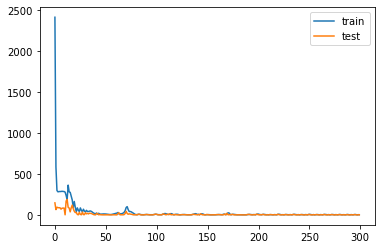

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

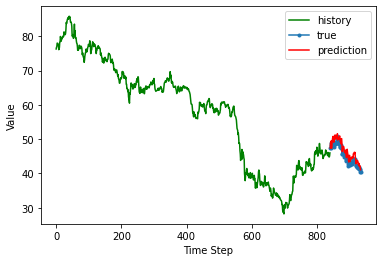

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

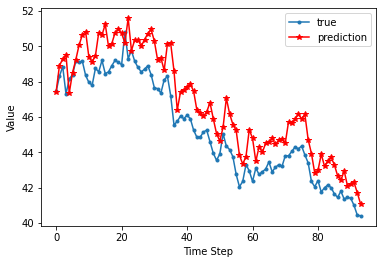

In [19]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
mean_absolute_percentage_error(y_test,y_pred)*100

3.2155910699370813

In [21]:
mean_squared_error(y_test,y_pred)

2.5820351189619766

In [22]:
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_true-y_pred)
    mbe = diff.mean()
    print('MBE = ', mbe)

MBE(y_test,y_pred)

MBE =  -1.423111692388007


In [23]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
[1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
Predicted direction accuracy (Up/down):
0.4946236559139785
